In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [307]:
df = pd.read_csv('data.csv')
df = df[['Date/Time', 'Total Precip (in)']]
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)
df = df.fillna(0)

monthly_precip = df['Total Precip (in)'].resample('M').sum()

monthly_precip = pd.DataFrame(monthly_precip)

monthly_precip.head()

/var/folders/fy/0g2tq1jx5hx58s7k13drt_4h0000gn/T/ipykernel_88437/3460420690.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_precip = df['Total Precip (in)'].resample('M').sum()


,Total Precip (in)
Date/Time,
2020-01-31,1.43
2020-02-29,3.30
2020-03-31,3.35
2020-04-30,4.33
2020-05-31,2.21


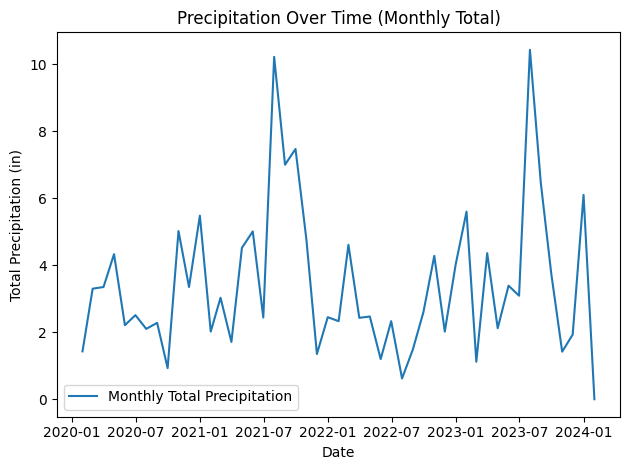

In [308]:
plt.plot(monthly_precip, label='Monthly Total Precipitation')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('Precipitation Over Time (Monthly Total)')
plt.legend()
plt.tight_layout()
plt.show()

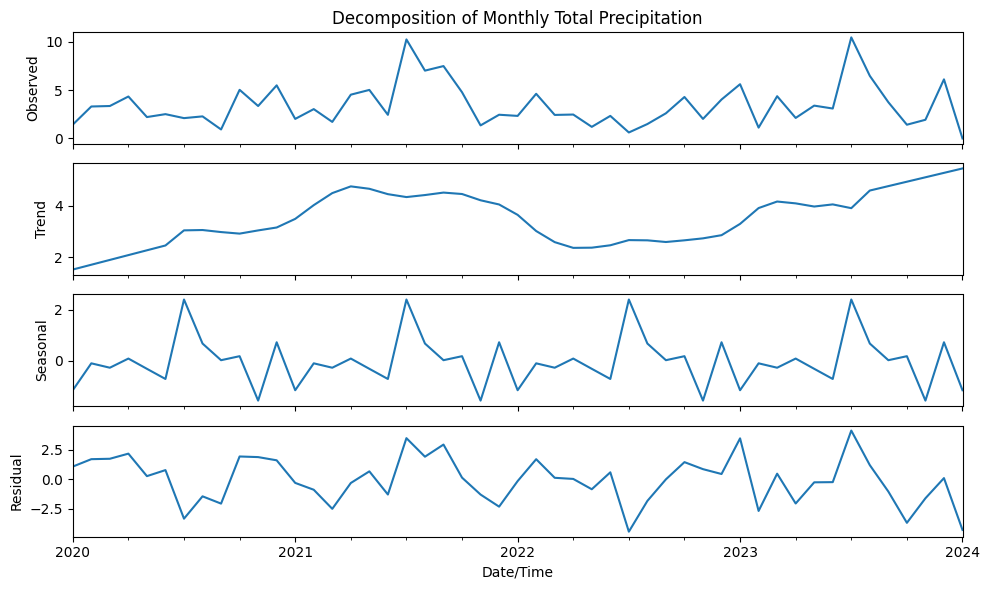

In [ ]:
decomposition = seasonal_decompose(monthly_precip, model='additive', period=12, extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True)
ax[0].set_title('Decomposition of Monthly Total Precipitation')
decomposition.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomposition.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

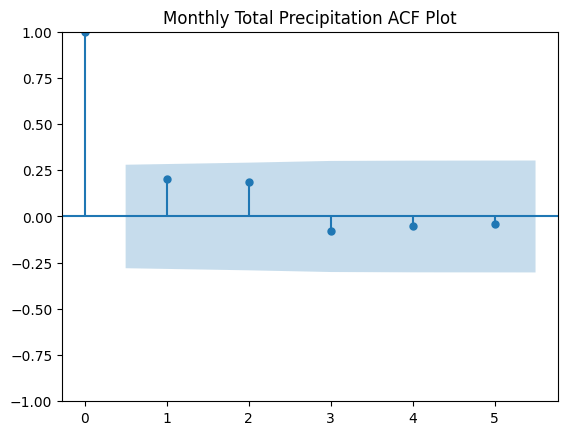

In [310]:
plot_acf(monthly_precip, title='Monthly Total Precipitation ACF Plot', lags=5)
plt.show()

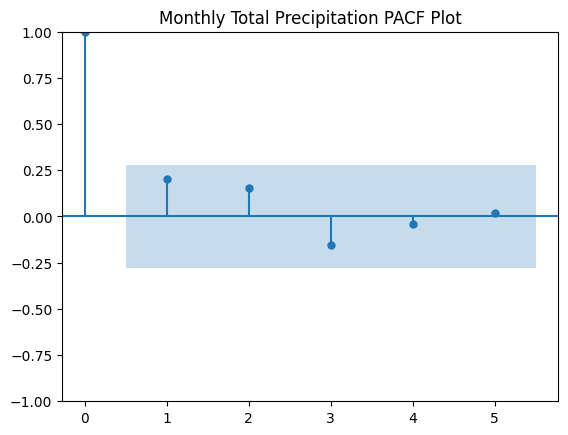

In [311]:
plot_pacf(monthly_precip, title='Monthly Total Precipitation PACF Plot', lags=5)
plt.show()

In [312]:
precip_array = monthly_precip.values.reshape(-1, 1)

train_size = int(0.8 * len(precip_array))
y_train = precip_array[:train_size]
y_test = precip_array[train_size:]

In [313]:
y_train_flat = y_train.flatten()
ar_model = AutoReg(y_train_flat, lags=2, trend='n')
ar_results = ar_model.fit()

print(ar_results.summary())
print("Roots:", ar_results.roots)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   39
Model:                     AutoReg(2)   Log Likelihood                 -78.530
Method:               Conditional MLE   S.D. of innovations              2.021
Date:                Tue, 08 Apr 2025   AIC                            163.059
Time:                        17:04:03   BIC                            167.892
Sample:                             2   HQIC                           164.763
                                   39                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.4179      0.147      2.841      0.004       0.130       0.706
y.L2           0.4880      0.147      3.321      0.001       0.200       0.776
                                    Roots           

In [314]:
ar_pred = ar_results.predict(
    start=len(y_train), 
    end=len(y_train) + len(y_test) - 1
)

test_index = monthly_precip.index[len(y_train):len(y_train) + len(y_test)]

pred_data = pd.DataFrame({
    'Date': test_index,
    'Predicted Precipitation': ar_pred.flatten()
}).set_index('Date')

pred_data.head()

,Predicted Precipitation
Date,
2023-04-30,2.368573
2023-05-31,3.117662
2023-06-30,2.458784
2023-07-31,2.549042
2023-08-31,2.265196


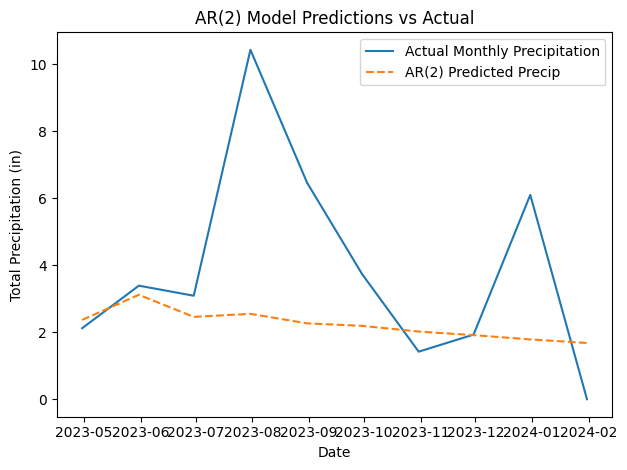

In [315]:
actual_test = pd.Series(
    y_test.flatten(), 
    index=monthly_precip.index[len(y_train):len(y_train) + len(y_test)]
)

plt.plot(actual_test, label='Actual Monthly Precipitation')
plt.plot(pred_data['Predicted Precipitation'], label='AR(2) Predicted Precip', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('AR(2) Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

In [316]:
y_pred = pred_data['Predicted Precipitation'].values

ararmae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {ararmae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 2.14
Root Mean Squared Error: 3.23


In [317]:
ma_model = ARIMA(y_train, order=(0, 0, 2))
ma_results = ma_model.fit()

print(ma_results.summary())
print("MA Roots:", ma_results.maroots)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 -78.432
Date:                Tue, 08 Apr 2025   AIC                            164.865
Time:                        17:04:04   BIC                            171.519
Sample:                             0   HQIC                           167.252
                                 - 39                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2727      0.581      5.631      0.000       2.133       4.412
ma.L1          0.1869      0.139      1.342      0.180      -0.086       0.460
ma.L2          0.3935      0.208      1.895      0.0

In [318]:
ma_pred = ma_results.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1
)

test_index = monthly_precip.index[len(y_train):len(y_train) + len(y_test)]

pred_data = pd.DataFrame({
    'Date': test_index,
    'Predicted Precipitation': ma_pred.flatten()
}).set_index('Date')

pred_data.head()

,Predicted Precipitation
Date,
2023-04-30,2.227917
2023-05-31,3.464557
2023-06-30,3.272664
2023-07-31,3.272664
2023-08-31,3.272664


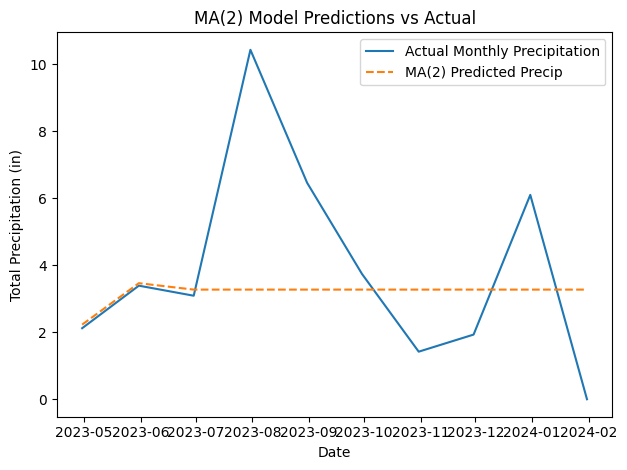

In [319]:
actual_test = pd.Series(
    y_test.flatten(),
    index=monthly_precip.index[len(y_train):len(y_train) + len(y_test)]
)

plt.plot(actual_test, label='Actual Monthly Precipitation')
plt.plot(pred_data['Predicted Precipitation'], label='MA(2) Predicted Precip', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('MA(2) Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

In [320]:
y_pred = pred_data['Predicted Precipitation'].values

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 2.05
Root Mean Squared Error: 2.93


In [321]:
arma_model = ARIMA(y_train, order=(2, 0, 2))
arma_results = arma_model.fit()

print(arma_results.summary())

print("AR Roots:", arma_results.arroots)
print("MA Roots:", arma_results.maroots)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -78.324
Date:                Tue, 08 Apr 2025   AIC                            168.648
Time:                        17:04:05   BIC                            178.630
Sample:                             0   HQIC                           172.230
                                 - 39                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2708      0.595      5.501      0.000       2.105       4.436
ar.L1          0.2198      0.773      0.284      0.776      -1.296       1.736
ar.L2         -0.1070      0.579     -0.185      0.8

In [322]:
arma_pred = arma_results.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1
)

test_index = monthly_precip.index[len(y_train):len(y_train) + len(y_test)]

pred_data = pd.DataFrame({
    'Date': test_index,
    'Predicted Precipitation': arma_pred.flatten()
}).set_index('Date')

pred_data.head()

,Predicted Precipitation
Date,
2023-04-30,2.488585
2023-05-31,3.218264
2023-06-30,3.342896
2023-07-31,3.292247
2023-08-31,3.267784


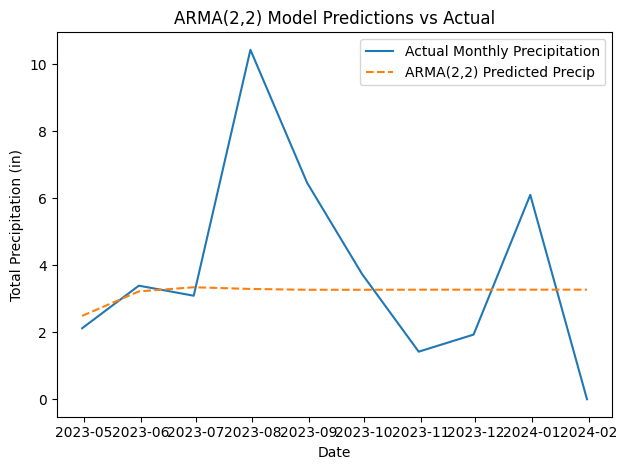

In [323]:
actual_test = pd.Series(
    y_test.flatten(),
    index=monthly_precip.index[len(y_train):len(y_train) + len(y_test)]
)

plt.plot(actual_test, label='Actual Monthly Precipitation')
plt.plot(pred_data['Predicted Precipitation'], label='ARMA(2,2) Predicted Precip', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (in)')
plt.title('ARMA(2,2) Model Predictions vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

In [324]:
y_pred = pred_data['Predicted Precipitation'].values

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 2.09
Root Mean Squared Error: 2.92
